# dag_prf_utils demos

A basic overview on surface plotting, and colormaps: 

More details in surface plotting in other notebooks

[1] Freeview: There are also a bunch of command line tools you can use with this. For quick useable stuff. Essentially all plotting requires freesurfer, so it is worth getting used to this. 

[2] Pycortex: beautiful. If you dig into it there are also many cool things you can do with hosting etc. However, some aspects are a little buggy / browser dependent. In particular plotting with 2D colormaps which is important for PRF mapping. 

[3] Plotly + dash based. I really like using this, allows you to do some cool interactive things. (also option for single htmls, less interactive though). 

Other formats...

[4] Generic .ply based plotting (export to a .ply mesh. Open with meshlab)

[5] Blender

[6] Colormaps



In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
from dag_prf_utils.prfpy_ts_plotter import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# FOR MY OWN TESTING OF THIS EXAMPLE FOLDER
# -> Freesurfer directory
sub = 'sub-02'
fs_dir = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer'

# -> load design matrix, time series and prfpy parameters from one of my projects
# 
from pfa_scripts.load_saved_info import *
prfpy_numpy_array = load_data_prf('sub-02', 'AS0', 'gauss')['AS0']['gauss']
time_series = load_data_tc(sub=sub, ses='ses-1', task_list='AS0', )['AS0']
design_matrix = get_design_matrix_npy(['AS0'])['AS0'][:,:,5:]         

# Create prfpy stimulus & model
assert design_matrix.shape[-1]==time_series.shape[-1]
prf_stim = PRFStimulus2D(
    screen_size_cm=39.3,                                    # height of the screen (i.e., the diameter of the stimulated region)    
    screen_distance_cm=196,                                 # Distance of screen to eye
    design_matrix=design_matrix,                            # dm (npix x npix x time_points)
    TR=1.5,                                                 # TR
    )   
prfpy_model = Iso2DGaussianModel(stimulus=prf_stim)

# Now make the "ts plotter": which will make plotting our prf information very easy
prfs  = TSPlotter(
    prf_params=prfpy_numpy_array,
    model='gauss',
    prfpy_model=prfpy_model,
    real_ts=time_series
)

# If you don't want to work with prfpy directly -> just load your own version for some of these
# ** Control visibility of data ** [using mask, or alpha, or both...] 
# If you don't want to show the values of every point (for example because it is outside the visual cortex). You may want to hide it. 
# If you are plotting PRFs, then you may want to hide the bad fits. So you can create a mask for where the rsq<threshold (e.g., 0.1)
# data_mask: what to show (TRUE), what to hide (FALSE)
# -> should boolean 1D np.ndarray, where the length = number of vertices in subject surface
# -> if unspecified, all surface functions assume TRUE for all voxels
# data_alpha: transparency (invisible = 0), (opaque = 1).
# Often you will do this based on the rsquared of your model

polar_angle_data = prfs.pd_params['pol'].to_numpy()
eccentricity_data = prfs.pd_params['ecc'].to_numpy()
data_mask = prfs.return_vx_mask(th={'min-rsq':.1, 'max-ecc':5})
data_rsq = prfs.pd_params['rsq'].to_numpy()
data_alpha = data_rsq.copy()


/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/prf_no_hrf/sub-02/ses-1/sub-02_model-gauss_roi-all_task-AS0-fits_stage-iter_constr-tc_desc-prf_params.pkl
prf_params.shape[-1]=8
include hrf = True
include rsq = True


In [ ]:
# sub = 'sub-02'                                      # Subject number
# fs_dir = '~/home/project1/derivatives/freesurfer'   # e.g., /home/project1/derivatives/freesurfer

# # Load some data to plot on the surface (e.g., PRF eccentricity and polar angle):
# # -> should 1D np.ndarray, where the length = number of vertices in subject surface

# polar_angle_data = np.load('path/to/subjects/polar/angle/data')
# eccentricity_data = np.load('path/to/subjects/polar/angle/data')



# data_mask = np.load('path/to/some/mask')

# -> should be 1D np.ndarray, min=0, max=1.  where the length = number of vertices in subject surface
# -> you could for example take the rsquared values of PRF fits and use this to determine the visibility of the prf data...
# data_alpha = np.load('path/to/some/alpha/values')



### [1] Using freeview
* requires freeview 
* Specify the data, the mesh, and the mask (you can only use binary masking, the option for varying the transparency is not available here). 
* scripts will create a custom surf file, and the command (which contains the colormap info) to open it in freeview
* The colormap can be anything from matplotlib. Just specify the min and max values. (https://matplotlib.org/stable/tutorials/colors/colormaps.html)
* You can also specify the camera angle for when freeview opens, and ask it to automatically take a picture of the surface. This can be useful if you want to iterate through several subjects/surface plots and save the figures as pngs, but can't be bothered to sit and click again and again... 

In [7]:
from dag_prf_utils.fs_tools import FSMaker
fs = FSMaker(sub=sub,fs_dir=fs_dir)

# Add polar angle plot
fs.add_surface(
    data = polar_angle_data,
    surf_name = f'{sub}-polar_angle',    
    vmin = -3.14, vmax=3.14, # min and max values of polar anlge 
    data_mask=data_mask,
    cmap = 'marco_pol', # A colleague (Marco Aqil) suggested this custom color map for polar angles. I called it 'marco_pol'
)

# Add eccentricity
fs.add_surface(
    data = eccentricity_data,
    surf_name = f'{sub}-eccentricity',    
    vmin = 0, vmax = 5, # min and max values of eccentricity
    data_mask=data_mask,
    cmap = 'ecc', # Also a custom map for eccentricity, which scales nicely. (again you can use anything you like, including developing your own. ) 
)

Using fs dir = /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer
marco_pol exists
Saving sub-02-polar_angle in /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer/sub-02/surf/custom
ecc exists
Saving sub-02-eccentricity in /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer/sub-02/surf/custom


In [8]:
# Now we can open one of the surfaces in freeview
fs.open_fs_surface(
    surf_name=f'{sub}-polar_angle',
    mesh = 'inflated',          # what type of surface? inflated? pial?
    )

freeview -f  lh.inflated:overlay=/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer/sub-02/surf/custom/lh.sub-02-polar_angle:overlay_custom=-3.14,255,0,0,-2.81,255,166,0,-2.48,186,220,0,-2.15,29,142,0,-1.82,0,223,191,-1.49,0,160,255,-1.16,0,43,255,-0.83,97,53,248,-0.50,235,128,238,-0.17,249,41,76,0.17,255,81,0,0.50,252,253,0,0.83,104,179,0,1.16,0,157,58,1.49,0,235,215,1.82,0,125,255,2.15,27,15,253,2.48,174,95,242,2.81,243,84,155,3.14,255,0,0, rh.inflated:overlay=/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer/sub-02/surf/custom/rh.sub-02-polar_angle:overlay_custom=-3.14,255,0,0,-2.81,255,166,0,-2.48,186,220,0,-2.15,29,142,0,-1.82,0,223,191,-1.49,0,160,255,-1.16,0,43,255,-0.83,97,53,248,-0.50,235,128,238,-0.17,249,41,76,0.17,255,81,0,0.50,252,253,0,0.83,104,179,0,1.16,0,157,58,1.49,0,235,215,1.82,0,125,255,2.15,27,15,253,2.48,174,95,242,2.81,243,84,155,3.14,255,0,0, --camera Azimuth 90 Zoom 1 Elevation 0 Roll 0 --c

QXcbConnection: XCB error: 11 (BadAlloc), sequence: 1394, resource id: 1307, major code: 53 (CreatePixmap), minor code: 0
QXcbConnection: XCB error: 4 (BadPixmap), sequence: 1624, resource id: 54526050, major code: 54 (FreePixmap), minor code: 0
QXcbConnection: XCB error: 4 (BadPixmap), sequence: 1624, resource id: 54526050, major code: 54 (FreePixmap), minor code: 0


I've written many possible things you can do with this. See the notes for 'write_fs_cmd'

For write_fs_cmd
        '''
        Write the bash command to open the specific surface with the overlay

        **kwargs 
        surf_name       which surface(s) to open (of the custom ones you have made)
        mesh_list       which mesh(es) to plot the surface info on (e.g., inflated, pial...)
        hemi_list       which hemispheres to load
        roi_list        which roi outlines to load
        roi_col_spec    if loading rois, what color? If not specified will do different colors for each nes     
        roi_mask        mask by roi?
        keep_running    keep running the command (use "&" at the end of the command). Useful if you want to take many screen shots.
        shading_off     Turn of shading? i.e., don't make it darker underneath. Default is false        
        do_scrn_shot    bool            take a screenshot of the surface when it is loaded?
        scr_shot_file   str             Where to put the screenshot. If not specified goes in custom surface dir
        azimuth         float           camera angle(0-360) Default: 0
        zoom            float           camera zoom         Default: 1.00
        elevation       float           camera angle(0-360) Default: 0
        roll            float           camera angle(0-360) Default: 0        
        do_col_bar      bool            show color bar at the end. Default is true
        '''

See also dag_make_overlay_str

In [9]:
# Maybe we want to open with a specific cameram angle and take a screenshot?
scr_shot_file = './z_screenshots'
if not os.path.exists(scr_shot_file):
    os.makedirs(scr_shot_file)
scr_shot_file = os.path.abspath(scr_shot_file)
fs.open_fs_surface(
    surf_name=f'{sub}-polar_angle',
    mesh = 'inflated',          # what type of surface? inflated? pial?
    hemi_list= 'lh', 
    do_scr_shot = True,
    scr_shot_file = os.path.join(scr_shot_file,'eg.png'), # Where to put it?
    # *** camera angles ***
    azimuth = 10, zoom = 1, elevation=5, roll=0, 
    )

freeview -f  lh.inflated:overlay=/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer/sub-02/surf/custom/lh.sub-02-polar_angle:overlay_custom=-3.14,255,0,0,-2.81,255,166,0,-2.48,186,220,0,-2.15,29,142,0,-1.82,0,223,191,-1.49,0,160,255,-1.16,0,43,255,-0.83,97,53,248,-0.50,235,128,238,-0.17,249,41,76,0.17,255,81,0,0.50,252,253,0,0.83,104,179,0,1.16,0,157,58,1.49,0,235,215,1.82,0,125,255,2.15,27,15,253,2.48,174,95,242,2.81,243,84,155,3.14,255,0,0, --camera Azimuth 10 Zoom 1 Elevation 5 Roll 0 --colorscale --ss /data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/notebooks/z_screenshots/eg.png 5 autotrim  --verbose  --viewport 3d --viewsize 99999 99999 --nocursor 
freeview -f  lh.inflated:overlay=/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer/sub-02/surf/custom/lh.sub-02-polar_angle:overlay_custom=-3.14,255,0,0,-2.81,255,166,0,-2.48,186,220,0,-2.15,29,142,0,-1.82,0,223,191,-1.49,0,160,255,-1.16,0,43,25

QXcbConnection: XCB error: 11 (BadAlloc), sequence: 1253, resource id: 1307, major code: 53 (CreatePixmap), minor code: 0
QXcbConnection: XCB error: 11 (BadAlloc), sequence: 1253, resource id: 1307, major code: 53 (CreatePixmap), minor code: 0
QXcbConnection: XCB error: 4 (BadPixmap), sequence: 1604, resource id: 54526045, major code: 54 (FreePixmap), minor code: 0
QXcbConnection: XCB error: 4 (BadPixmap), sequence: 1604, resource id: 54526045, major code: 54 (FreePixmap), minor code: 0


Command line options
Inside /bin/

See the functions themselves for specifics  
```

dag_auto_FS_surf_from_file          Automatically make freesurfer surfaces given a .npy or pickle file (i.e., from saved prf parameters)

dag_clean_custom_surfs              Remove custom surfaces put in the subjects FS dir

dag_make_fs_overlay                 Make an fs_overlay (something you can load in freesurfer to determine the colomap)

dag_open_sub_surf                   Open any subjects surface in there custom surf folder, inside freesurfer (i.e. surfaces that you have made before)

dag_print_custom_rois               Print all the rois matching a certain pattern in a FS folder

dag_print_custom_surfs              Print all the surfaces matching a certain pattern in a FS folder

```

***

### Using pycortex
* requires pycortex 
* as above

In [10]:
from dag_prf_utils.pycortex import set_ctx_path,PyctxMaker
# Make sure pycortex is pointing to correct folder
ctx_path = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/pycortex'
set_ctx_path(ctx_path)

pm = PyctxMaker(
    sub = sub,
    fs_dir = fs_dir, 
    output_dir = 'z_pyctx',
    ctx_path=ctx_path,
    )
# Add polar angle plot
pm.add_vertex_obj(
    data = polar_angle_data,
    surf_name = f'{sub}-polar_angle',    
    vmin = -3.14, vmax=3.14, # min and max values of polar anlge 
    data_mask=data_mask,
    cmap = 'marco_pol', # A colleague (Marco Aqil) suggested this custom color map for polar angles. I called it 'marco_pol'
)

# Add eccentricity
pm.add_vertex_obj(
    data = eccentricity_data,
    surf_name = f'{sub}-eccentricity',    
    vmin = 0, vmax = 5, # min and max values of eccentricity
    data_mask=data_mask,
    cmap = 'ecc2', # Also a custom map for eccentricity, which scales nicely. (again you can use anything you like, including developing your own. ) 
)


Using fs dir = /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/pycortex
default
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/pycortex/sub-02


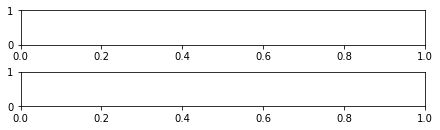

In [11]:
# To open from here:
pm.return_pyc_saver(
    save_cm=True,
    viewer=False, # open or don;t open the webviewer
)


# To save as a static file 
pm.pyc.to_static(filename='blah_static') # to save as static file 
# to run just do 
# python -m http.server 8000 
# open http://localhost:8000 in browser


***

### Plotly plotting
* requires plotly library (conda install)
* You can plot a mesh inline in a notebook! 
* You can also export it to an html file, which any computer can read! They will be able to interact with it too
* Can put more than one in a single html (i.e., subfigures)
* Also an online interactive clicky thing!


In [12]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from dag_prf_utils.mesh_dash import dag_mesh_pickle, MeshDash

##### To make interactive dash in browser
You can toggle the:
* rsq threshold
* inflation (pial-inflated)
* colormaps (any possible matplolib); vmin, vmax
* show ROIs, or not... 

In [13]:

fs = MeshDash(
    sub, 
    fs_dir=fs_dir,
    output_dir='z_dash',
    )
fs.web_get_ready()
fs.web_add_vx_col(
    data=polar_angle_data,
    data4mask =data_rsq,
    vmin=-np.pi, vmax=np.pi, 
    cmap='marco_pol', 
    vx_col_name=f'pol'
)

fs.web_add_vx_col(
    data=eccentricity_data, 
    data4mask =data_rsq,
    cmap='ecc2', 
    vmin=0, vmax=5, 
    vx_col_name=f'ecc'
)

# Other cool things....
# you can add ROIs
fs.web_add_roi(roi_list='V1')

# You can also add conditional functions to do plotting. 
# For example if you have a function to plot the timeseries put that here 
def my_plot_function(vertex_id):
    fig = plt.figure()
    # Do some plotting based on the vertex...
    return fig

fs.web_add_mpl_fig_maker(my_plot_function) # you can add more than one...



Using fs dir = /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...


In [14]:
# To launch app from here 
# app = fs.web_launch_with_dash(assets_type='boring') # change to exciting to use silly fonts...
# Open the app in a browser (or in the notebook)
# app.run_server(mode='external', host='127.0.0.1', port=8000, debug=False, use_reloader=False) 
# Go to localhost:8000 in your browser to see the app.

In [15]:
# To save it to a pickle 
dag_mesh_pickle(fs) # dumps it as a pickle file

# Use /bin/dag_open_dash_surf <pickle-file> to open and launch the file again
# If you get the error
# PicklingError: Can't pickle <class 'dag_prf_utils.mesh_dash.MeshDash'>: it's not the same object as dag_prf_utils.mesh_dash.MeshDash
# Try restarting your kernel and running again...

pickling mesh_dash object to : z_dash/mesh_dash.pkl


Also can do automatic loading of prf parameter files 

bin/dag_auto_dash_surf_from_file 

##### To export html files (don't bother with dash, less interactive)

In [16]:

gmm = MeshDash(
    sub=sub, 
    fs_dir=fs_dir,
    output_dir='z_gmm_plotly') # Make the 'generic mesh maker' instance
# Make 2 plots side by side showing polar angle and eccentricity

n_rows = 1
n_cols = 2

# Create plotly fig with subplots
fig = make_subplots(rows=n_rows, cols=n_cols, specs=[[{'type': 'surface'}]*n_cols]*n_rows, )
# First polar angle
mesh_plot = gmm.add_plotly_surface(
    data=polar_angle_data, 
    data_mask=data_mask, 
    cmap='marco_pol', 
    vmin=-3.14, 
    vmax=3.14,
    return_mesh_obj=True,
)
fig.append_trace(mesh_plot[0], row=1, col=1) # Add left hemisphere
# fig.append_trace(mesh_plot[1], row=1, col=1) # Add right hemisphere

# Same again for eccentricity
mesh_plot = gmm.add_plotly_surface(
    data=eccentricity_data, 
    data_mask=data_mask, 
    cmap='ecc', 
    vmin=0, 
    vmax=5,
    return_mesh_obj=True,
)
fig.append_trace(mesh_plot[0], row=1, col=2) # Add left hemisphere
# fig.append_trace(mesh_plot[1], row=1, col=2) # Add right hemisphere


Using fs dir = /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
No vx to mask
No vx to mask
No vx to mask
No vx to mask


In [17]:

# Now show the figure inline in the notebook
# Play around with the different surfaces
# fig.show() # show inline
# fig.show(renderer='browser') # show with browser


In [18]:
# You can also create an HTML file. Save it and open it with your browser
fig.write_html('z_eg_plotly_html.html')

***

### Generic .ply format
* requires freesurfer + any software capable of opening .ply files. My suggestion is MeshLab
* Specify the data, the mesh, and the mask (including an option for variable transparency). 
* can create a single .ply file (per hemisphere), which contains all the information about the mesh (vx coordinates, face id); the data values for each vertex, and a color value for each vertex (determined by the data, and specified colormap). 
* This can be opened by most 3D viewing software (e.g., meshlab, blender)...


In [19]:
from dag_prf_utils.mesh_maker import GenMeshMaker
# Make the 'generic mesh maker' instance
gmm = GenMeshMaker(
    sub=sub, 
    fs_dir=fs_dir,
    output_dir='z_gmm_ply') 

# Create the .ply surfaces
gmm.add_ply_surface(
    surf_name='polar-angle',
    data=polar_angle_data, 
    data_mask=data_mask, 
    cmap='marco_pol', 
    vmin=-3.14, 
    vmax=3.14,
)

# Same again for eccentricity
gmm.add_ply_surface(
    surf_name='eccentricity',
    data=eccentricity_data, 
    data_mask=data_mask, 
    cmap='ecc', 
    vmin=0, 
    vmax=5,
)

Using fs dir = /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
File to be named: polar-angle
Writing: polar-angle for sub-02
File to be named: eccentricity
Writing: eccentricity for sub-02


In [20]:
# Open them with your software of choice
gmm.open_ply_mlab() # e.g., meshlab

/data1/projects/dumoulinlab/Lab_members/Marcus/programs/MeshLab2022.02-linux/usr/bin/meshlab: error while loading shared libraries: libmeshlab-common.so: cannot open shared object file: No such file or directory


***

### Blender
* requires freesurfer and blender
* a powerful approach and allows for a lot of customization (due to the blender api flexibility, which can be called via python)
* The script will load the inflated and pial mesh, with the option to slide between the 2 (i.e. customize how inflated you want the surface to be)
* You can load several colormaps at once, and flip between them 
* If you are feeling adventurous, you can even create an animation over time, (e.g., plot timecourse info on the surface). This is a bit experimental, and may take up a lot of data and computing power. I haven't fully explored it. 


In [21]:
from dag_prf_utils.blender_tools import BlendMaker
bm = BlendMaker(
    sub=sub,
    fs_dir=fs_dir,
    output_dir='z_blend',    
    ow=True, 
)
# This will create a folder with 4 .ply meshes
# -> left-inflated, right-inflated, left-pial, right-pial
# & 2 csv files with rgb information for:
# -> cortical curvature, cortical thickness

Using fs dir = /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Overwriting existing file
Making z_blend


In [22]:

# Add polar angle plot
bm.add_blender_cmap(
    data=polar_angle_data,
    surf_name=f'{sub}-polar_angle',
    data_mask=data_mask,
    # data_alpha=data_alpha,
    vmin = -3.14, vmax=3.14, # min and max values of polar anlge 
    cmap = 'marco_pol',
)
# Add eccentricity
bm.add_blender_cmap(
    data=eccentricity_data,
    surf_name=f'{sub}-ecc',
    data_mask=data_mask,
    # data_alpha=data_alpha,
    vmin = 0, vmax=5, # min and max values of polar anlge 
    cmap = 'ecc',
)
# -> polar_angle, and eccentricity
# If the alpha is too blurry, just use data mask...

In [23]:
# Now we can launch blender, and load in the .ply files and the rgb data...
bm.launch_blender() # creates a startup script for the blender file
# navigate to the output directory and run:
# blender --python blender_script.py
# If you have issues check the blender_script.py for errors (common issue is the path)

This may take a while. But once it is done, you can save everything together as one .blender file. You can open this file on its own, and everything will load very quickly. (so you only need to run this once, unless you change the data...)

You can then do a number of cool things:

* Inflate & deflate the hemispheres:    
    * Select the hemisphere (click on it; it should then have an orange line outlining it). 
    * Click on the green triangle on the panel on the right
    * Got to "shape keys"
    * Click on interpolated
    * There is a slider named "Value". Change the value here from 0-1 to inflate & deflate the hemisphere
* Switch between different plots:
    * Select the hemisphere (click on it)
    * Click on the green triangle on the panel on the right
    * Go to color attributes
    * Click on what you want to show on the surface (e.g., polar_angle, curvature etc.)